# Behavioral Analysis

This notebook analyze the behavioral performance of individual sessions.

In [1]:
%config Completer.use_jedi = False

In [2]:
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

from convnwb.io import load_nwbfile
from convnwb.io import get_files, save_json

from spiketools.plts.utils import make_axes, save_figure
from spiketools.plts.data import plot_bar, plot_hist
from spiketools.plts.style import drop_spines
from spiketools.utils.base import count_elements

In [3]:
import sys
sys.path.append('../code')
from utils import (compute_recall_percent, get_confidence_response)
from plts import plot_distance_error, plot_recall_correctness, plot_confidence_response

In [4]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [5]:
# Define the base data folder
data_folder = '/Users/clairehan/Documents/Data/JacobsLab/WVTH/NWB'

## Load data

In [14]:
# Get the list of NWB files
nwbfiles = get_files(data_folder)

In [15]:
# Get the list of NWB files running THO, THF respectively
nwbfiles_THF = get_files(data_folder, select='THF')
nwbfiles_THO = get_files(data_folder, select='THO')

In [6]:
# Define session information
session = {
    'experiment' : 'THF',
    'subject' : 'wv001',
    'session' : 0
}

In [8]:
# Load example NWB file
nwbfile = load_nwbfile(session, data_folder)

## Units per task

In [48]:
# Get the number of keep units per session 
units_session = np.zeros(len(nwbfiles))
for ind, nwbfile in enumerate(nwbfiles):
    nwbfile, io = load_nwbfile(nwbfile, data_folder, return_io=True)
    units_session[ind] = len(np.where(nwbfile.units.keep[:])[0])

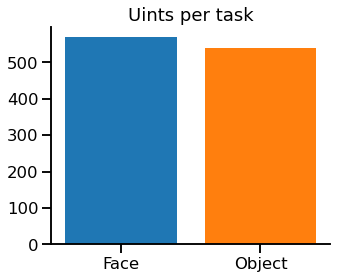

In [76]:
_, ax = plt.subplots(figsize=(5, 4))
plot_bar([sum(units_session[1:10]), sum(units_session[11:22])], ['Face', 'Object'], 
         color=['C0', 'C1'], title='Uints per task', ax=ax)
drop_spines(ax, ['top', 'right']) 

## Units per brain region & hemisphere

In [69]:
# Get the number of units per brain region
labels = ['LAH', 'RAH', 'LA', 'RA', 'RAH', 'RPH']
unit_all = []
for ind, nwbfile in enumerate(nwbfiles):
    nwbfile, io = load_nwbfile(nwbfile, data_folder, return_io=True)
    unit = nwbfile.units['location'].data[:]
    unit_all.append(unit)

unit_all = np.concatenate(unit_all).ravel()
unit_counts = count_elements(unit_all, labels=labels)

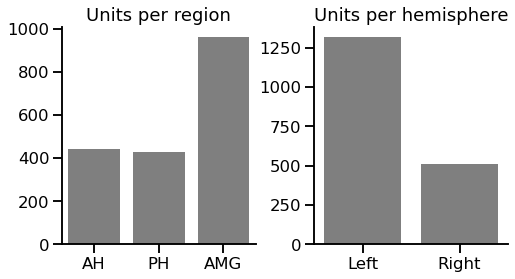

In [97]:
ax1, ax2 = make_axes(2, 2, figsize=(8, 4), wspace=0.3)
plot_bar([unit_counts['LAH'] + unit_counts['RAH'], unit_counts['LPH'] + unit_counts['RPH'], unit_counts['LA'] + 
          unit_counts['RA']], ['AH', 'PH', 'AMG'], title='Units per region', color='C7', ax=ax1)
plot_bar([unit_counts['LAH'] + unit_counts['LPH'] + unit_counts['LA'], unit_counts['RAH'] + unit_counts['RPH'] 
          + unit_counts['RA']], ['Left', 'Right'], title='Units per hemisphere', color='C7', ax=ax2)
drop_spines(ax1, ['top', 'right'])
drop_spines(ax2, ['top', 'right'])

In [ ]:
# {"LAH": 81, "LPH": 120, "LA": 224, "RA": 60, "RAH": 36, "RPH": 26}
# {"LAH": 112, "LPH": 118, "LA": 229, "RA": 103, "RAH": 56, "RPH": 25}

## Recall correctness

In [131]:
# plot % of recall for one-back data
behav_nback = sio.loadmat('/Users/clairehan/Desktop/research/WVTH/BehAcc.mat')
correct_OBF = (behav_nback['AccCel'][0])*100
correct_OBO = (behav_nback['AccImg'][0])*100

In [132]:
# Compute the percentage of recall for all data, and for each task
# correct_all = compute_recall_percent(nwbfiles, data_folder)
correct_THF = compute_recall_percent(nwbfiles_THF, data_folder)
correct_THO = compute_recall_percent(nwbfiles_THO, data_folder)

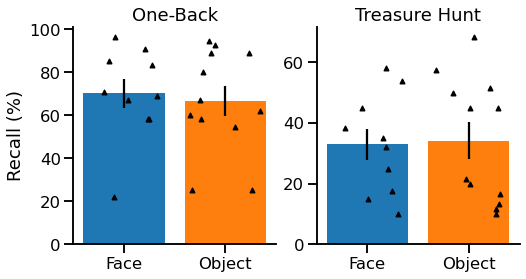

In [139]:
ax1, ax2 = make_axes(2, 2, figsize=(8,4))
drop_spines(ax1, ['top', 'right'])
drop_spines(ax2, ['top', 'right'])

plot_bar([correct_OBF.mean(0), correct_OBO.mean(0)], ['Face', 'Object'], ylabel='Recall (%)', title='One-Back',
         yerr=[sem(correct_OBF, 0), sem(correct_OBO, 0)], ax=ax1, color=['C0', 'C1'], zorder=0)
plot_bar([correct_THF.mean(0), correct_THO.mean(0)], ['Face', 'Object'], title='Treasure Hunt',
         yerr=[sem(correct_THF, 0), sem(correct_THO, 0)], ax=ax2, color=['C0', 'C1'], zorder=0)

x = [0,1]
y_OB = [correct_OBF, correct_OBO]
y_TH = [correct_THF, correct_THO]
w=0.7

for i in range(len(x)):
    ax1.scatter(x[i] + np.random.random(y_OB[i].size) * w - w / 2, y_OB[i], color='black', marker='^', s=20)
    ax2.scatter(x[i] + np.random.random(y_TH[i].size) * w - w / 2, y_TH[i], color='black', marker='^', s=20)
    

## Confidence response

In [32]:
# Count the number of confidence response in each category across sessions
[conf_all, conf_THF, conf_THO] = Counter({'yes': 0, 'maybe':0, 'no':0})
labels = ['yes', 'maybe', 'no']

# conf_all = get_confidence_response(nwbfiles, data_folder, labels)
conf_THF = get_confidence_response(nwbfiles_THF, data_folder, labels)
conf_THO = get_confidence_response(nwbfiles_THO, data_folder, labels)

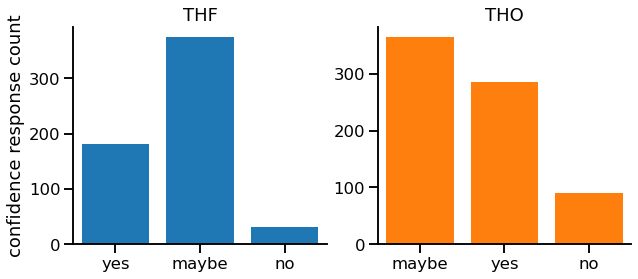

In [110]:
ax1, ax2 = make_axes(2, 2, figsize=(10, 4))
plot_bar(conf_THF.values(), labels=conf_THF.keys(), ylabel='confidence response count', title='THF', ax=ax1, color='C0')
plot_bar(conf_THO.values(), labels=conf_THO.keys(), title='THO', ax=ax2, color='C1')

drop_spines(ax1, ['top', 'right'])
drop_spines(ax2, ['top', 'right'])

## Successful vs. Unsuccessful recall
To-Dos:
* add behavioral analysis for successful vs. unsuccessful recall